# Make a synthetic dataset with SpikeInterface

This notebook does the following:
1. Create a synthetic tetrode recording with [SpikeInterface](https://github.com/SpikeInterface/spikeinterface)
2. Write a simple helper function to plot a subset of the trace and the true spike times
3. Convert the traces and spike times/IDs to PyTorch tensors for the assignment.


**Notes**
- I tried using real data from Chung and Frank (2017), but without ground truth labels it's hard to make a compelling lab.
- I updated `SpikeInterface` to allow finer-grained control of the noise and to center the spike within each template.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import spikeinterface.extractors as se

## Create synthetic dataset

In [2]:
duration = 60 * 2               # seconds
num_channels = 4                # tetrode array
num_units = 8                   # true number of neurons
sampling_frequency = 30_000     # Hz
average_peak_amplitude = -100.0 # uV
noise_levels = 10.0             # uV   
# noise_correlations = np.array([[1.0, 0.5, 0.0, 0.0],
#                                [0.5, 1.0, 0.0, 0.0],
#                                [0.0, 0.0, 1.0, 0.5],
#                                [0.0, 0.0, 0.5, 1.0]])
noise_correlations = np.eye(num_channels)

recording, true_sorting, true_templates = \
    se.toy_example(duration=duration, 
                   num_channels=num_channels, 
                   num_units=num_units, 
                   sampling_frequency=sampling_frequency, 
                   num_segments=1, 
                   average_peak_amplitude=average_peak_amplitude,
                   noise_levels=noise_levels,
                   noise_correlations=noise_correlations,
                   seed=0)

traces = recording.get_traces()
spike_times, spike_unit_ids = true_sorting.get_all_spike_trains()[0]

/var/folders/d1/fsjj9s5n5sdfzt5nrbrkq30m0000gn/T/ipykernel_39611/2228369751.py:25: DeprecationWarning: Sorting.get_all_spike_trains() will be deprecated. Sorting.to_spike_vector() instead
  spike_times, spike_unit_ids = true_sorting.get_all_spike_trains()[0]


### Z-score the traces

In [3]:
scales = traces.std(axis=0)
traces = (traces - traces.mean(axis=0)) / scales

In [4]:
spike_unit_ids = np.array(spike_unit_ids, dtype=int)
np.unique(spike_unit_ids)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [5]:
def plot_slice(traces, 
               spike_times, 
               spike_unit_ids,
               sampling_frequency,
               start_time=0,
               end_time=1.0,
               spacing=0.8):
    """
    Plot a slice of the recording and the corresponding spike times.

    """
    slc = slice(int(start_time * sampling_frequency), int(end_time * sampling_frequency))
    spc = abs(traces[slc]).max() * spacing
    times = np.arange(0, len(traces)) / sampling_frequency

    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(times[spike_times], spike_unit_ids, '|k', markersize=8)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(np.arange(0, num_units))

    for i in range(num_channels):
        axs[1].plot(times, traces[:, i] + spc * i, color='k', lw=1, alpha=0.5)

    axs[1].set_yticks(np.arange(0, num_channels) * spc)
    axs[1].set_yticklabels(np.arange(0, num_channels))
    axs[1].set_ylabel("channel")
    axs[1].set_ylim(-spc, num_channels * spc)
    axs[1].set_xlim(start_time, end_time)
    axs[1].set_xlabel(f"time [sec]")
    return fig, axs

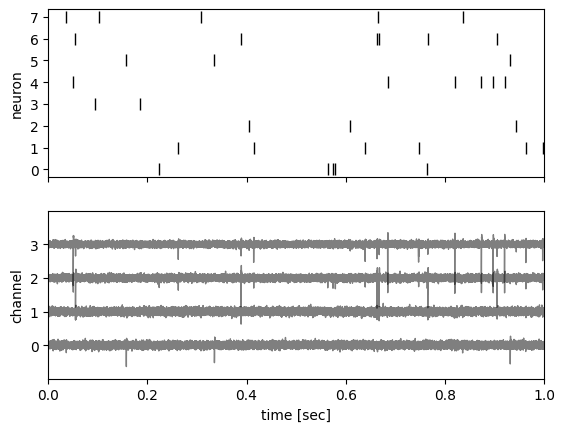

In [6]:
_ = plot_slice(traces, spike_times, spike_unit_ids, sampling_frequency, start_time=0, end_time=1.0)

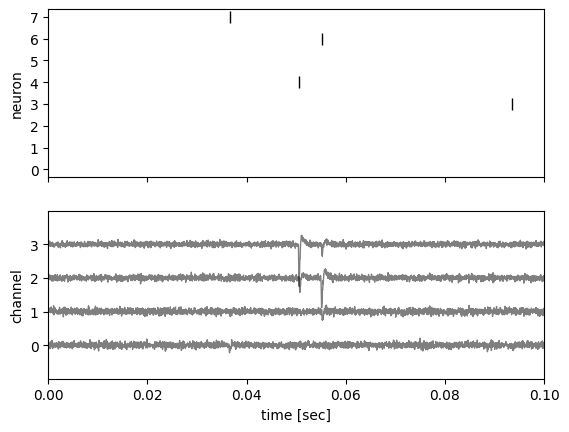

In [7]:
_ = plot_slice(traces, spike_times, spike_unit_ids, sampling_frequency, start_time=0.0, end_time=0.1)

Compute the covariance of the traces. It should look like the specified noise correlations. 

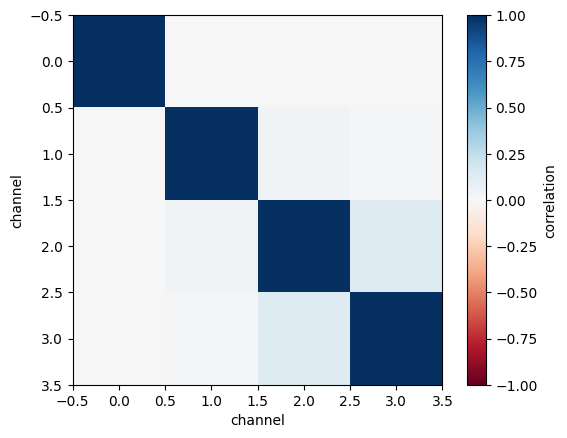

In [8]:
plt.imshow(np.corrcoef(traces.T), cmap='RdBu', interpolation='none', vmin=-1, vmax=1)
plt.xlabel("channel")
plt.xlabel("channel")
plt.ylabel("channel")
plt.colorbar(label=r"correlation")

## Convert to PyTorch

In [9]:
torch.save(dict(traces=torch.tensor(traces),
                true_spike_times=torch.tensor(spike_times),
                true_spike_ids=torch.tensor(spike_unit_ids),
                true_templates=torch.tensor(true_templates) / scales,
                sampling_frequency=sampling_frequency,),
           "lab01_data.pt")

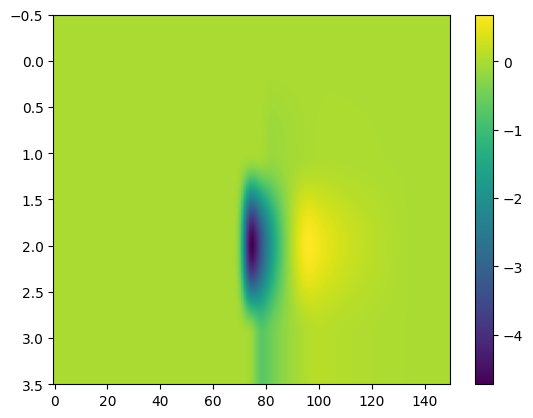

In [14]:
plt.imshow((true_templates / scales)[0].T, aspect="auto")
plt.colorbar()